In [2]:
# add a description
# this should be for generating the velocity/acceleration/jerk plots 

In [5]:
from hsflfm.analysis import build_bulk_analyzer 
import numpy as np 
from matplotlib import pyplot as plt 
from build_grid import build_grid

import os 
from pathlib import Path 
import numpy as np 
import torch 
from tqdm import tqdm 
from matplotlib import pyplot as plt 
import matplotlib 
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from hsflfm.calibration import FLF_System
from scipy.spatial import ConvexHull, Delaunay
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from scipy.stats import spearmanr, linregress
from hsflfm.analysis import get_peak_indices, world_frame_to_pixel
from hsflfm.analysis import BulkAnalyzer, ResultPlotter, ResultManager
from hsflfm.util import load_dictionary, MetadataManager, save_dictionary, matmul 

total # points: 14061
after enforcing error threshold: 11556
82.2%


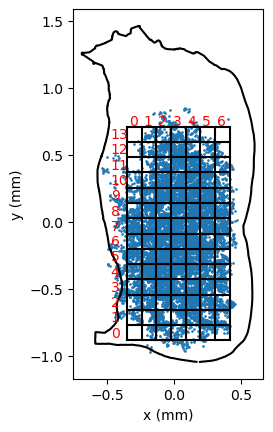

In [4]:
result_folder = "../complete_results_20241227"
result_folder = "../complete_results_pseudo_inverse_20250803"

reload = False   
analyzer = build_bulk_analyzer(result_folder, reload=reload)

# remove all points that don't meet a defined error threshold
# error threhsold is in pixels^2 
total_points = len(analyzer.all_results["specimen_number"])
analyzer.enforce_error_threshold(0.0015) 
safe_points = len(analyzer.all_results["specimen_number"])

print(f"total # points: {total_points}")
print(f"after enforcing error threshold: {safe_points}")
print(f"{safe_points/total_points * 100:.1f}%")

x_bounds, y_bounds = build_grid(analyzer=analyzer, show_numbers=True)

In [37]:
# we have to open each result file to build the trajectories
# so ideally these are completed once and saved 
def get_save_trajectories(grid, radius, reload=False):
    save_name = f"{result_folder}/grid_{grid[0]}_{grid[1]}_trajectories.json"

    if not os.path.exists(save_name) or reload:
        centerx_0 = (x_bounds[grid[0]] + x_bounds[grid[0] + 1]) / 2
        centery_0 = (y_bounds[grid[1]] + y_bounds[grid[1] + 1]) / 2

        start_buffer = 15
        end_buffer = 14

        center0 = [centerx_0, centery_0]

        # this is inefficient but I'm just looping through and re-finding 
        # what specimen numbers and strike numbers have a point in this saddle region
        specimen_numbers = [] 
        strike_numbers = [] 
        mandible_orders = []

        exclude_count = 0 
        include_count = 0
        for specimen in np.unique(analyzer.all_results["specimen_number"]): 
            mm = MetadataManager(specimen) 
            for strike_number in mm.strike_numbers:
                strike_points = analyzer.get_specimen_indices(specimen, strike_number=strike_number)
                strike_locations = analyzer.all_results["start_locations_std"][strike_points].numpy() 
                distances = np.linalg.norm(strike_locations[:, :2] - center0, axis=1)
                if np.count_nonzero(distances < radius) < 1:
                    exclude_count += 1
                    continue 

                # check frame rate 
                data = mm.get_strike_data(strike_number) 
                if data["Frame Rate"].values[0] != 1e5:
                    exclude_count +=1 
                    continue 

                strike_numbers.append(strike_number) 
                specimen_numbers.append(specimen) 
                mandible_orders.append(mm.mandible_order(strike_number))
                include_count +=1 


        all_trajectories = np.zeros((1, len(strike_numbers), start_buffer + end_buffer, 3))
        peak_displacements = np.zeros((1, len(strike_numbers), 3))

        k = 0
        for k, (specimen, strike_number) in enumerate(tqdm(zip(specimen_numbers, strike_numbers))):
            filename = result_folder + f'/{specimen}/strike_{strike_number}_results.json'
            assert os.path.exists(filename)  

            results = load_dictionary(filename) 
            rm = ResultManager(results)
            strike_center = rm.strike_center_index()
            start = strike_center - start_buffer
            end = strike_center + end_buffer
            offset = 0
            if start < 0:
                offset = abs(start)
                start = 0

            if end > rm.rel_displacements.shape[1]: 
                end_offset = -(end - rm.rel_displacements.shape[1]) 
                end = rm.rel_displacements.shape[1] 
            else:
                end_offset = rm.rel_displacements.shape[1]

            # find point_indices in the two circles 
            std_locs = rm.point_start_locs_ant_std.numpy()

            for i, center in enumerate([center0]): 
                distances = np.linalg.norm((std_locs[:, :2] - center), axis=1) 
                idx = np.where(distances < radius)[0] 
                good_indices = np.where(rm.error_scores < 0.0015)[0] 
                idx = np.intersect1d(idx, good_indices) 

                traj = rm.rel_displacements[idx, start:end] 
                traj = torch.mean(traj, axis=0).tolist() 

                all_trajectories[i, k, offset:end_offset] = traj 

                pd = torch.concatenate((rm.peak_displacements(0)[None], rm.peak_displacements(1)[None],
                                        rm.peak_displacements(2)[None]), axis=0)
                
                pd = torch.mean(pd[:, idx], axis=1).numpy()
                peak_displacements[i, k] = pd 

        res = {
            "specimen_numbers": [str(i) for i in specimen_numbers], 
            "strike_numbers": [int(i) for i in strike_numbers], 
            "mandible_orders": mandible_orders, 
            "all_trajectories": all_trajectories, 
            "peak_displacements": peak_displacements
        }

        save_dictionary(res, save_name) 

    else:
        res = load_dictionary(save_name)

    return res 

grid = [8, 3] 
radius = 200 
res = get_save_trajectories(grid, radius)

Text(0.5, 1.0, 'quick check')

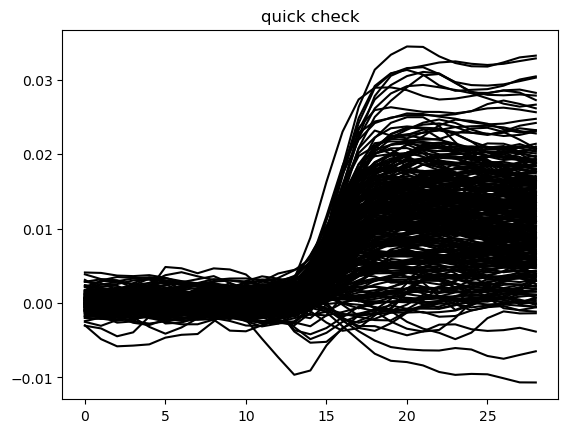

In [38]:
results = {} 
for key, item in res.items():
    results[key] = np.asarray(item).squeeze()

for p in results["all_trajectories"]:
    plt.plot(p[:, 2], color='black')
plt.title("quick check") 

In [39]:
# trajectories should be a numpy array of shape (# points, # frames, 3)
# or (# points, # frames)
def normalize(trajectories, cutoff=8):
    item_norm = trajectories
    if len(item_norm.shape) == 3:
        item_norm = np.linalg.norm(trajectories, axis=-1) 
    
    # this could be done in a cleaner way
    for i, line in enumerate(item_norm):
        item_norm[i] = line - line[0]
    assert len(item_norm.shape) == 2 
    peak_indices = get_peak_indices(torch.from_numpy(item_norm)) 
    peak_values = item_norm[np.arange(item_norm.shape[0]), peak_indices.numpy()]

    idx = peak_values > cutoff

    # theres a better way to do this
    traj_n = np.zeros_like(item_norm) 
    for i, line in enumerate(item_norm): 
        traj_n[i] = line / peak_values[i]

    return traj_n[idx] 

0: mean 13.41483, std 6.64821, (295,)
1: mean 0.32700, std 0.16829, (295,)
2: mean 0.01219, std 0.00589, (295,)
3: mean 0.00067, std 0.00026, (295,)


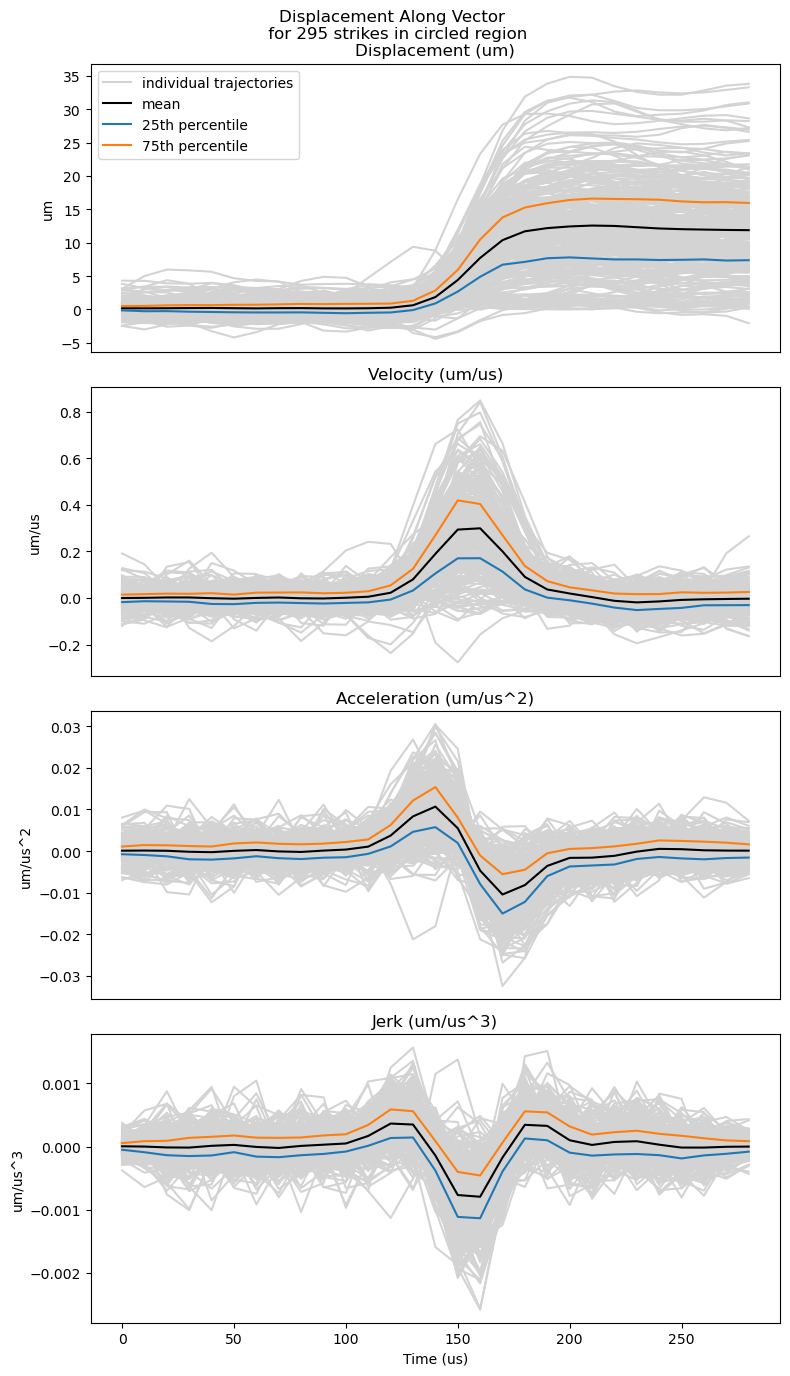

In [63]:
n = 4
normalize_this = False     

if normalize_this:
    unit = "AU" 
    tag = "Normalized " 
    unit2 = "% peak displacement"
else:
    unit = "um" 
    tag = ""
    unit2 = unit

values = results["all_trajectories"] * 1e3 
a = np.mean(values, axis=1) 
a = a / np.linalg.norm(a, axis=-1)[:, None] 
# find a more efficient way to do this 
new_values = np.zeros((values.shape[0], values.shape[1]))
for i, p in enumerate(values):
    vector = a[i]
    p = [np.dot(x, vector) for x in p] 
    new_values[i] = p
values = new_values

if normalize_this:
    values = normalize(values)

first_values = values 
# find a key to highlight 
mv = np.max(values, axis=1) 
diff = np.abs(mv - 22)  
highlight_key = np.argmin(diff)

fig, axes = plt.subplots(n, 1, figsize=(8, 14))
time = np.arange(values.shape[1]) / 1e5 * 1e6
for i in range(n):
    scale = 10**(-i) 

    ax = axes[i]
    for p in values:
        ax.plot(time, p*scale, color='lightgray')
    # repeat for label purposes 
    ax.plot(time, values[0]*scale, color='lightgray', 
            label="individual trajectories")
    avg = np.mean(values, axis=0) 
    ax.plot(time, avg*scale, color='black', label="mean") 
    
    low = np.percentile(values, 25, axis=0)
    ax.plot(time, low*scale, label="25th percentile") 
    high =  np.percentile(values, 75, axis=0) 
    ax.plot(time, high*scale, label="75th percentile") 

    max_values = np.max(values, axis=1) * scale 
    print(f"{i}: mean {np.mean(max_values):.5f}, std {np.std(max_values):.5f}, {max_values.shape}")

    values = np.gradient(values, axis=1) 
    if i != n - 1:
        ax.set_xticks([]) 
    if i == 0:
        ax.legend()

ax = axes[n - 1]
ax.set_xlabel("Time (us)") 

axes[0].set_ylabel(f"{unit}") 
axes[0].set_title(f"{tag}Displacement ({unit2})")

axes[1].set_ylabel(f"{unit}/us") 
axes[1].set_title(f"{tag}Velocity ({unit2}/us)")

axes[2].set_ylabel(f"{unit}/us^2") 
axes[2].set_title(f"{tag}Acceleration ({unit2}/us^2)")

axes[3].set_ylabel(f"{unit}/us^3") 
axes[3].set_title(f"{tag}Jerk ({unit2}/us^3)")

fig.suptitle(f"{tag}Displacement Along Vector \n for {values.shape[0]} strikes in circled region")
plt.tight_layout()

In [48]:
# and show the trajectories in other regions 
all_trajectories = {} 
grid_regions = {
    "saddle": [8, 3], 
    "top": [11, 3],
    "side": [6, 0],
    "bottom": [2, 3],
}
radius = 200
for key, grid in grid_regions.items():
    res = get_save_trajectories(grid, radius)
    all_trajectories[key] = np.asarray(res["all_trajectories"]).squeeze()

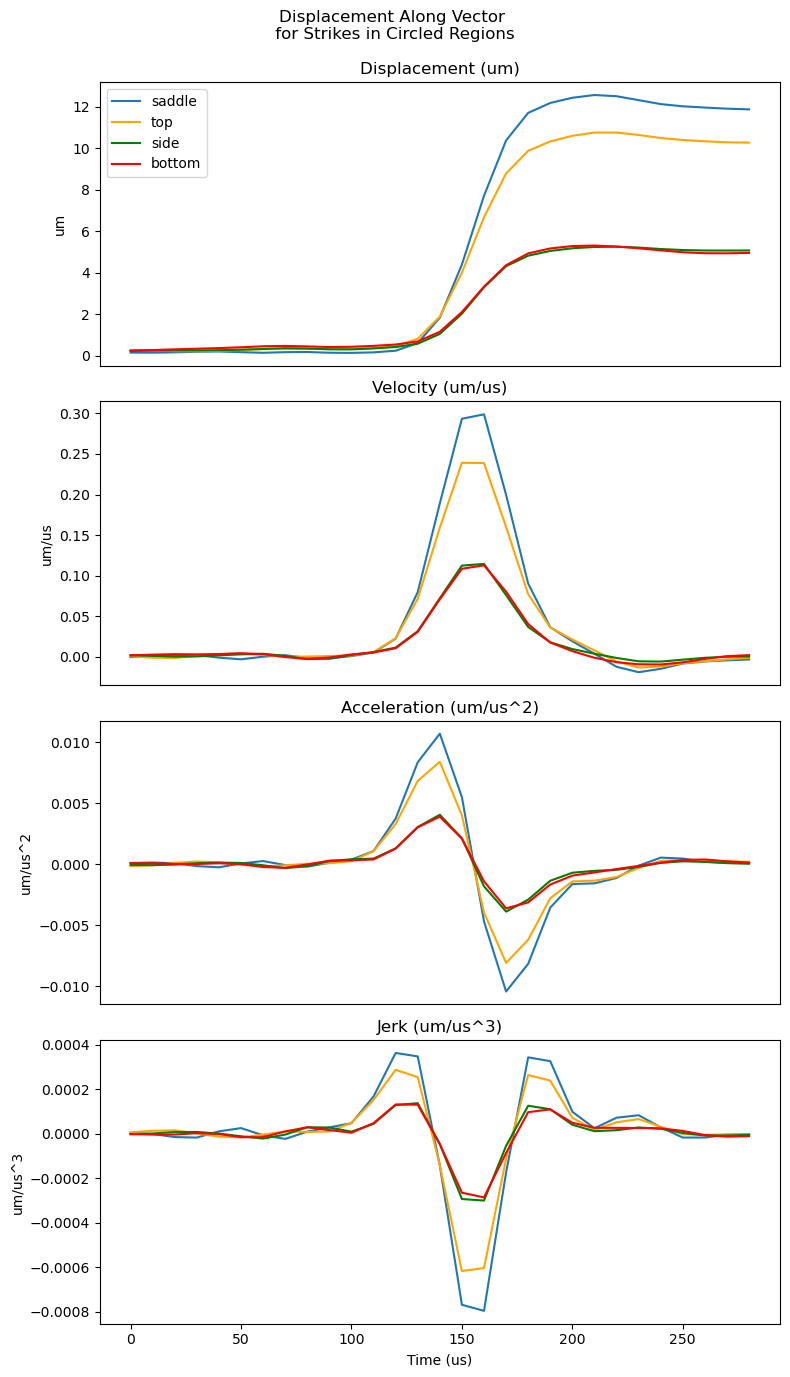

In [57]:
colors = {
    "saddle": "#1f77b4", 
    "top": "orange", 
    "side": "green", 
    "bottom": "red"
}

cutoffs = {
    "saddle": 8, 
    "top": 6, 
    "side": 5,
    "bottom": 6
}

n = 4 
normalize_this = False  
if normalize_this:
    unit = "AU" 
    tag = "Normalized " 
    unit2 = "% peak displacement"
else:
    unit = "um" 
    tag = ""
    unit2 = unit
fig, axes = plt.subplots(n, 1, figsize=(8, 14)) 
for key, values in all_trajectories.items():
    values = values * 1e3 
    a = np.mean(values, axis=1) 
    a = a / np.linalg.norm(a, axis=-1)[:, None]  
    # find a more efficient way to do this 
    new_values = np.zeros((values.shape[0], values.shape[1]))
    for i, p in enumerate(values):
        vector = a[i]
        p = [np.dot(x, vector) for x in p] 
        new_values[i] = p
    values = new_values


    if normalize_this:
        values = normalize(values, cutoff=cutoffs[key]) 

    label = key 
    time = np.arange(values.shape[1]) / 1e5 * 1e6

    for i in range(n):
        scale = 10**(-i) 
        ax = axes[i] 
        avg = np.mean(values, axis=0) 
  
        ax.plot(time, avg*scale, label=label, color=colors[key]) 
        values = np.gradient(values, axis=1) 

        if i != n - 1:
            ax.set_xticks([]) 
        if i == 0:
            ax.legend()

ax = axes[n - 1]
ax.set_xlabel("Time (us)") 

axes[0].set_ylabel(f"{unit}") 
axes[0].set_title(f"{tag}Displacement ({unit2})")

axes[1].set_ylabel(f"{unit}/us") 
axes[1].set_title(f"{tag}Velocity ({unit2}/us)")

axes[2].set_ylabel(f"{unit}/us^2") 
axes[2].set_title(f"{tag}Acceleration ({unit2}/us^2)")

axes[3].set_ylabel(f"{unit}/us^3") 
axes[3].set_title(f"{tag}Jerk ({unit2}/us^3)")

fig.suptitle(f"{tag}Displacement Along Vector \n for Strikes in Circled Regions \n ")
plt.tight_layout()